# 📌 Projekt: Automatyczna Klasyfikacja Obrazów Fasoli

Celem biznesowym jest stworzenie i wdrożenie systemu rozpoznawania odmian fasoli na podstawie obrazów, który umożliwi automatyczną klasyfikację 12 różnych gatunków. Taki system może znaleźć zastosowanie w:

🔹Rolnictwie i przemyśle spożywczym – automatyzacja procesu sortowania fasoli, poprawa efektywności produkcji i kontroli jakości. 

🔹Handlu i dystrybucji – szybka identyfikacja odmian fasoli w magazynach i punktach sprzedaży, co może usprawnić zarządzanie zapasami.

🔹Badaniach i rozwoju – wsparcie dla naukowców i hodowców w analizie i selekcji fasoli pod kątem cech jakościowych.

Dzięki wykorzystaniu technik uczenia maszynowego możliwe będzie zwiększenie precyzji identyfikacji, redukcja błędów ludzkich oraz optymalizacja procesów logistycznych i produkcyjnych.

Źródło danych(podane po przypomnieniu od walidacji): https://www.kaggle.com/datasets/pratikgorde/hyacinth-bean-image-dataset


In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
import seaborn as sns
import hashlib
from collections import defaultdict

In [43]:
print(os.getcwd())

C:\Users\matja\Downloads\projekt_ML-main (1)\projekt_ML-main\OSTATECZNY PROJEKT


In [44]:
##Konieczne wywołanie dla treningowego zbioru w celu uzyskania cech, zmiana komentarza tu i w ostatniej komórce

#data_path="Dataset_split/train"
data_path="Dataset_split/test"

In [45]:
# Wprowadzenie dokładniejszych komentarzy i poprawienie czytelności projektu po wskazaniu tego przez walidację

## 🔹Eksploracja Danych

#### Sprawdzamy liczności poszczególnych kategorii

In [46]:
categories=os.listdir(data_path)

for category in categories:
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        print(f"{category}: {len(os.listdir(category_path))} images")

Bombali Ghevda: 80 images
Butka Ghevda: 80 images
Gabara Ghevda: 80 images
God Wal: 80 images
Hirva Lamb: 80 images
Kadu wal: 80 images
Kala Wal: 80 images
Lal lamb shenga: 80 images
Lamb Shiracha Ghevda: 80 images
Shravan Ghevda: 80 images
Tambda wal: 80 images
Vatana Ghevda: 80 images


#### Wczytujemy scieżki do obrazów do ramki danych

In [47]:

data = []
for class_folder in os.listdir(data_path):  
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):  
        for file in os.listdir(class_path):  
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):  
                data.append({"class": class_folder, "filename": file, "path": os.path.join(class_path, file)})


df = pd.DataFrame(data)


print(df.head())

            class     filename                                           path
0  Bombali Ghevda        1.jpg        Dataset_split/test\Bombali Ghevda\1.jpg
1  Bombali Ghevda       10.jpg       Dataset_split/test\Bombali Ghevda\10.jpg
2  Bombali Ghevda  10_aug0.jpg  Dataset_split/test\Bombali Ghevda\10_aug0.jpg
3  Bombali Ghevda  10_aug1.jpg  Dataset_split/test\Bombali Ghevda\10_aug1.jpg
4  Bombali Ghevda  10_aug2.jpg  Dataset_split/test\Bombali Ghevda\10_aug2.jpg


#### Podgląd losowych zdjęć ze zbioru, pierwsze zapoznanie z danymi

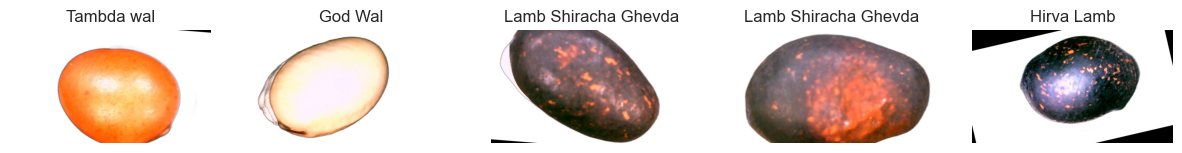

In [48]:
def plot_sample_images(data_path, categories, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        category = random.choice(categories)  
        img_name = random.choice(os.listdir(os.path.join(data_path, category))) 
        img_path = os.path.join(data_path, category, img_name)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(category)
        axes[i].axis("off")
    plt.show()

plot_sample_images(data_path, categories)

##### Widzimy podstawowe różnice 
###### ***1. Różny poziom zjęcia obszaru zdjęcia***
###### ***2. Tylko niektóre zdjęcia są ucięte - widoczne czarne pasy***

#### Badamy rozmiary zdjęć w zbiorze

In [49]:
sizes = []
for category in categories:
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):  
        img_path = os.path.join(category_path, img_name)
        with Image.open(img_path) as img:
            sizes.append(img.size)

print(set(sizes)) 

{(1920, 1080)}


##### Widzimy dwa różne rozmiary - mogłoby to powodować różnice przy ekstrakcji cech

#### Usuwamy kopie zduplikowanych zdjęć ze zbioru

In [50]:
hashes = set()
duplicates = 0

for category in categories:
    category_path = os.path.join(data_path, category)
    
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        
        with open(img_path, "rb") as f:
            img_hash = hashlib.md5(f.read()).hexdigest()
        
        if img_hash in hashes:
            duplicates += 1
            os.remove(img_path)  
            print(f"Usunięto duplikat: {img_path}")
        else:
            hashes.add(img_hash)

print(f"Liczba usuniętych duplikatów: {duplicates}")

Usunięto duplikat: Dataset_split/test\Shravan Ghevda\19.jpg
Usunięto duplikat: Dataset_split/test\Shravan Ghevda\20.jpg
Liczba usuniętych duplikatów: 2


#### Sprawdzamy liczności obrazów w podziale według rozmiaru

In [51]:
size_count = defaultdict(int)


for category in categories:
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        with Image.open(img_path) as img:
            size = img.size
            size_count[size] += 1 


for size, count in size_count.items():
    print(f"Rozmiar {size}: {count} obrazów")

Rozmiar (1920, 1080): 958 obrazów


#### Sprawdzamy czy obrazy nie są uszkodzone

In [52]:
def check_missing_images(data_path, categories):
    missing_images = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  
            except (IOError, SyntaxError) as e:
                missing_images.append(img_path)
    
    return missing_images

missing_images = check_missing_images(data_path, categories)
print(f"Znaleziono {len(missing_images)} uszkodzonych obrazów.")

Znaleziono 0 uszkodzonych obrazów.


In [53]:
df.info

<bound method DataFrame.info of               class     filename  \
0    Bombali Ghevda        1.jpg   
1    Bombali Ghevda       10.jpg   
2    Bombali Ghevda  10_aug0.jpg   
3    Bombali Ghevda  10_aug1.jpg   
4    Bombali Ghevda  10_aug2.jpg   
..              ...          ...   
955   Vatana Ghevda  23_aug3.jpg   
956   Vatana Ghevda   2_aug0.jpg   
957   Vatana Ghevda   2_aug1.jpg   
958   Vatana Ghevda   2_aug2.jpg   
959   Vatana Ghevda   2_aug3.jpg   

                                              path  
0          Dataset_split/test\Bombali Ghevda\1.jpg  
1         Dataset_split/test\Bombali Ghevda\10.jpg  
2    Dataset_split/test\Bombali Ghevda\10_aug0.jpg  
3    Dataset_split/test\Bombali Ghevda\10_aug1.jpg  
4    Dataset_split/test\Bombali Ghevda\10_aug2.jpg  
..                                             ...  
955   Dataset_split/test\Vatana Ghevda\23_aug3.jpg  
956    Dataset_split/test\Vatana Ghevda\2_aug0.jpg  
957    Dataset_split/test\Vatana Ghevda\2_aug1.jpg  
958  

#### Normalizujemy obrazy do jednego rozmiaru, zostawiamy czarne pasy - będziemy ich obecność uwzględniać przy ekstarkcji cech

Wszystkie obrazy zostały znormalizowane i nadpisane.


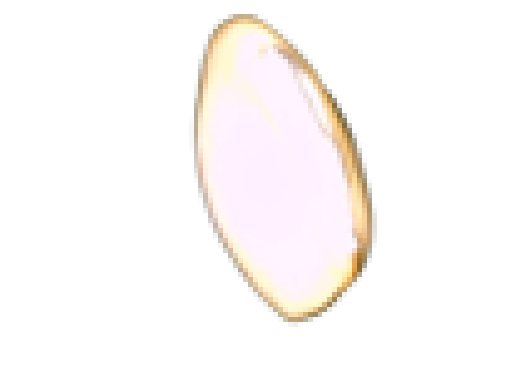

In [54]:
def normalize_image(img_path):
    with Image.open(img_path) as img:
        img = img.resize((100, 70))  
        img = img.convert("RGB")  
        img_array = np.array(img) / 255.0  
        return Image.fromarray((img_array * 255).astype(np.uint8))  

first_image = None  

for category in categories:
    category_path = os.path.join(data_path, category)
    for i, img_name in enumerate(os.listdir(category_path)):  
        img_path = os.path.join(category_path, img_name)
        
        normalized_img = normalize_image(img_path)
        normalized_img.save(img_path)  # Nadpisanie oryginalnego pliku

        if first_image is None:  # Zapisujemy pierwszy obraz do wyświetlenia
            first_image = normalized_img

print("Wszystkie obrazy zostały znormalizowane i nadpisane.")


if first_image:
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()

In [55]:
def image_brightness(img_path):
    if not os.path.exists(img_path):  
        return np.nan  
    
    with Image.open(img_path) as img:
        img_gray = img.convert("L")
        return np.array(img_gray).mean()

## 🔹Inżynieria cech (potencjalnie do dalszego rozwinięcia w przyszłości)

#### Badamy poziom jasności i kontrastu obrazów

In [56]:
# Podpunkt zasugerowany przez zespół walidacyjny
def image_contrast(img_path):
    with Image.open(img_path) as img:
        img_gray = img.convert("L")
        return np.array(img_gray).std()  
category_stats = {}
for category in categories:
    category_path = os.path.join(data_path, category)
    brightness_values = []
    contrast_values = []

    for img_name in os.listdir(category_path):  
        img_path = os.path.join(category_path, img_name)
        brightness_values.append(image_brightness(img_path))
        contrast_values.append(image_contrast(img_path))

    category_stats[category] = {
        "Średnia jasność": np.mean(brightness_values),
        "Średni kontrast": np.mean(contrast_values)
    }


for category, stats in category_stats.items():
    print(f"Kategoria: {category}")
    print(f"  Średnia jasność: {stats['Średnia jasność']:.2f}")
    print(f"  Średni kontrast: {stats['Średni kontrast']:.2f}")
    print()

Kategoria: Bombali Ghevda
  Średnia jasność: 219.37
  Średni kontrast: 58.94

Kategoria: Butka Ghevda
  Średnia jasność: 186.95
  Średni kontrast: 78.66

Kategoria: Gabara Ghevda
  Średnia jasność: 192.05
  Średni kontrast: 77.08

Kategoria: God Wal
  Średnia jasność: 219.50
  Średni kontrast: 60.14

Kategoria: Hirva Lamb
  Średnia jasność: 160.48
  Średni kontrast: 92.90

Kategoria: Kadu wal
  Średnia jasność: 221.78
  Średni kontrast: 57.83

Kategoria: Kala Wal
  Średnia jasność: 189.30
  Średni kontrast: 78.29

Kategoria: Lal lamb shenga
  Średnia jasność: 155.34
  Średni kontrast: 89.44

Kategoria: Lamb Shiracha Ghevda
  Średnia jasność: 147.45
  Średni kontrast: 87.48

Kategoria: Shravan Ghevda
  Średnia jasność: 217.66
  Średni kontrast: 58.17

Kategoria: Tambda wal
  Średnia jasność: 194.60
  Średni kontrast: 66.44

Kategoria: Vatana Ghevda
  Średnia jasność: 212.72
  Średni kontrast: 65.70



#### Badamy średnie wartości kanałów RGB dla każdego obrazu

In [57]:
def avg_color(img_path):
    """Oblicza średnią wartość kolorów RGB dla pojedynczego obrazu."""
    with Image.open(img_path) as img:
        img = img.resize((100, 70))  
        img_array = np.array(img)
        return np.mean(img_array, axis=(0, 1))

In [58]:
df = df[df["path"].apply(os.path.exists)].copy()

df["brightness"] = df["path"].apply(image_brightness)
df[["R", "G", "B"]] = df["path"].apply(lambda x: pd.Series(avg_color(x)))

##### Skala kolorów umożliwiająca rożrónianie klas fasolek

In [59]:
colors = [
    "#E6194B",  # Intensywny czerwony
    "#3CB44B",  # Jasny zielony
    "#FFE119",  # Żółty
    "#0082C8",  # Niebieski
    "#F58231",  # Pomarańczowy
    "#911EB4",  # Fioletowy
    "#46F0F0",  # Turkusowy
    "#F032E6",  # Magenta / różowy
    "#D2F53C",  # Limonkowy
    "#FABEBE",  # Jasnoczerwony / różowawy
    "#008080",  # Morski / ciemnoturkusowy
    "#E6BEFF",  # Jasny fiolet / lawenda
]

#### Przyjrzyjmy się rozkładowi jasności oraz średniej wartości dla kanałów RGB z uwzględnieniem klas

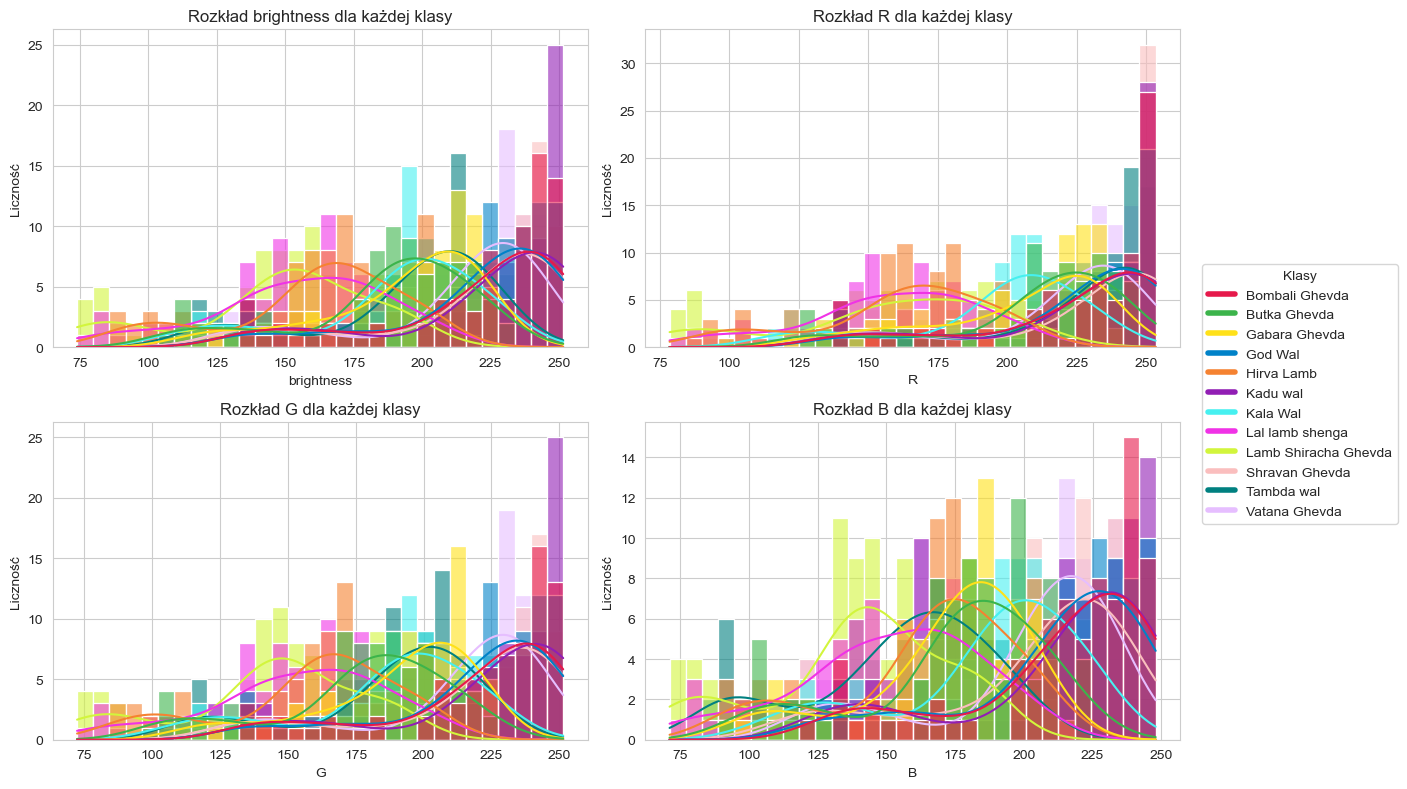

In [60]:

sns.set_style("whitegrid")

features = ["brightness", "R", "G", "B"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)

handles = []
labels = []


for ax, feature in zip(axes.flatten(), features):
    plot = sns.histplot(data=df, x=feature, hue="class", kde=True, bins=30, 
                        palette=colors, alpha=0.6, ax=ax)

    ax.set_title(f"Rozkład {feature} dla każdej klasy")
    ax.set_xlabel(feature)
    ax.set_ylabel("Liczność")


    if plot.legend_:
        for h, l in zip(*plot.get_legend_handles_labels()):
            if l not in labels:  
                handles.append(h)
                labels.append(l)

    ax.legend_.remove()


if not labels:
    labels = df["class"].unique().tolist()
    handles = [plt.Line2D([0], [0], color=sns.color_palette(colors)[i], lw=4) for i in range(len(labels))]


fig.legend(handles, labels, title="Klasy", loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Widzimy rozkład dwumodalny (zrówno dla całego zbioru jak i dla każdej klasy) o modach w okolicy 140 i 240
##### Prawdopodobnym powodem jest pozostawienie czarnych pasów - mocno obniżających średnie
##### Za wysokie wartości w każdej kategorii odpowiadać może białe tło

#### Boxploty dla każdej klasy 

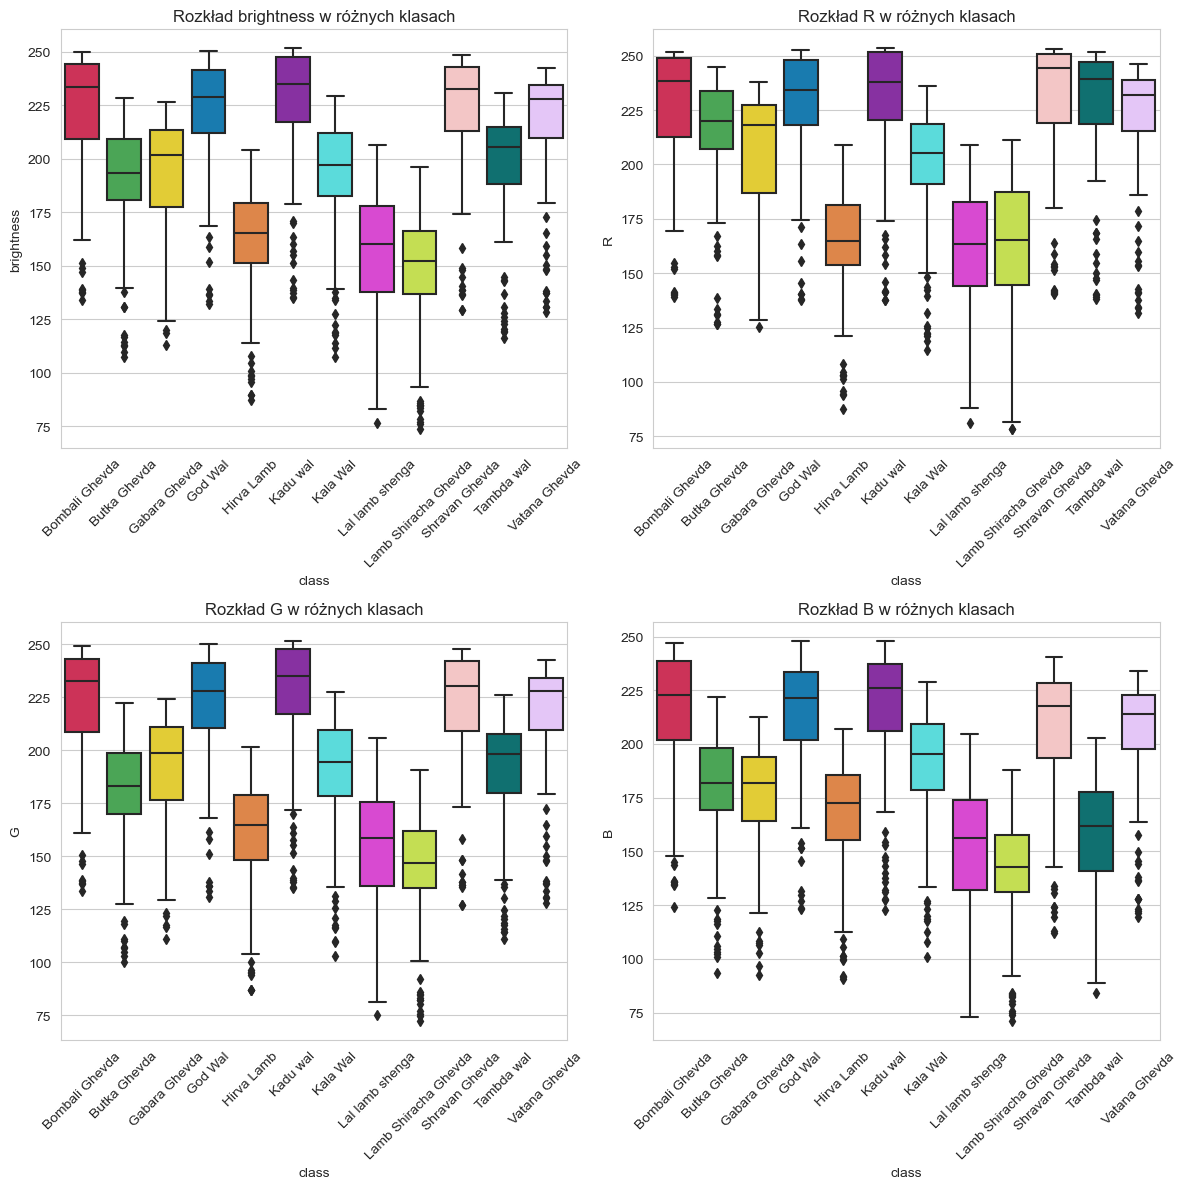

In [61]:

plt.figure(figsize=(12, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x="class", y=feature, palette=colors)
    plt.xticks(rotation=45)
    plt.title(f"Rozkład {feature} w różnych klasach")

plt.tight_layout()
plt.show()

##### Widzimy że dla danej klasy rozkłady każdej cech są do siebie zbliżone 
##### Dwa różne typy rozkładu:
##### ***1) Duży rozstęp międzykwartylowy***
##### ***2) mały rozstęp międzykwartylowy z licznymi wartościami odstającymi poniżej pierwszego kwartyla***

C:\Users\matja\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


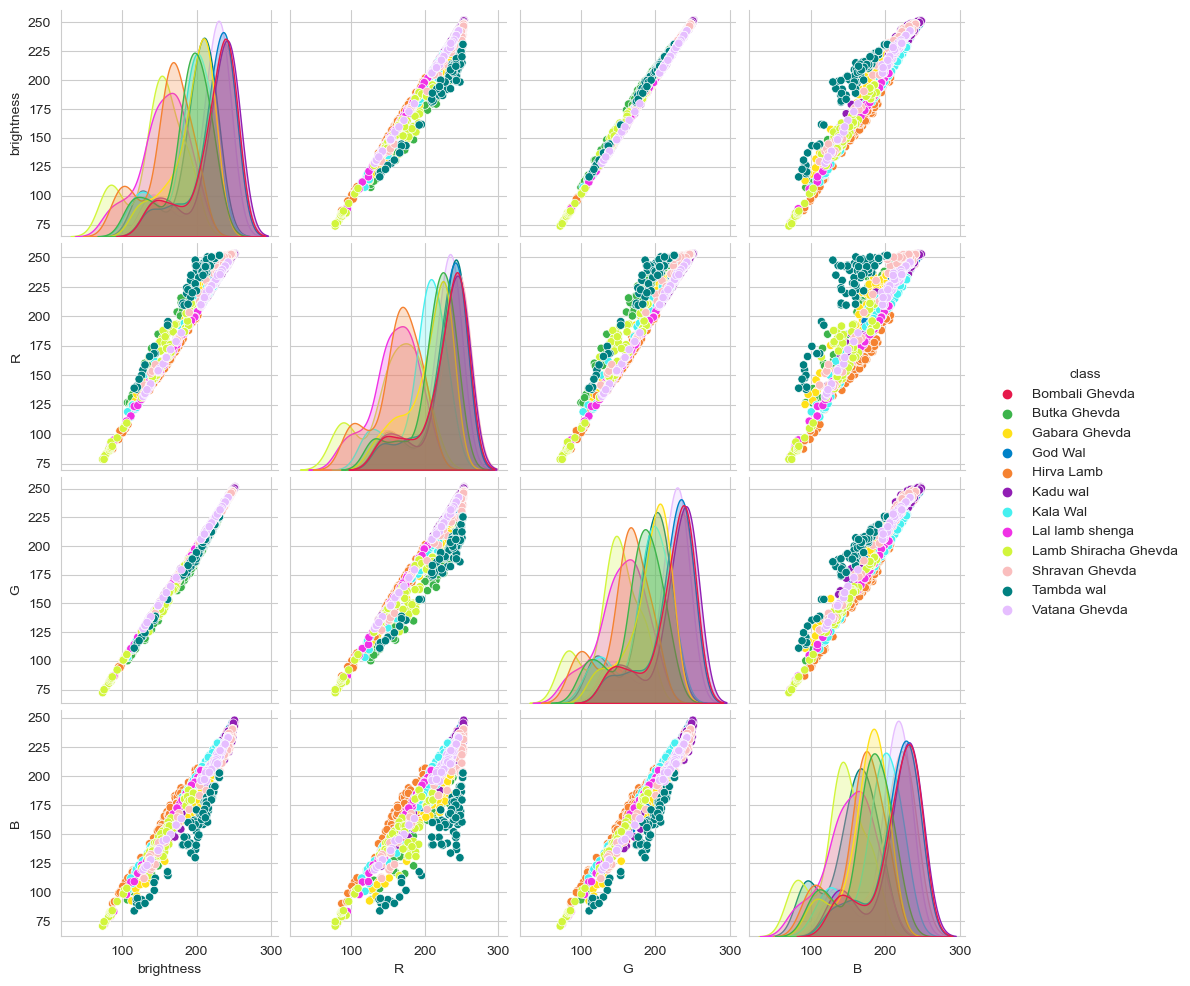

In [62]:
sns.pairplot(df, hue="class", diag_kind="kde", palette=colors)
plt.show()

##### Widzimy bardzo silną korelację zmiennych

##### Sprubójmy pominąć tło przy liczeniu średnich, skoncentrujmy się na pikselach o jasności z przedziału 3-250 (bez białego i czarnego)

##### Powtarzamy wcześniejsze kroki dla zmodyfikowanej funkcji liczącej średnią kolorów

In [63]:
def avg_color_without_white_and_black(img_path):
    """Oblicza średnią wartość kolorów RGB dla obrazu, ignorując piksele poniżej (3,3,3) i powyżej (250,250,250)."""
    with Image.open(img_path) as img:
        img = img.convert("RGB")  
         
        img_array = np.array(img)

        
        mask = np.all(img_array >= [3, 3, 3], axis=2) & np.all(img_array <= [250, 250, 250], axis=2)
        valid_pixels = img_array[mask]

        if len(valid_pixels) == 0:  
            return np.array([0, 0, 0])  

        avg_rgb = np.mean(valid_pixels.reshape(-1, 3), axis=0)  
        return avg_rgb

In [64]:
df[["R2", "G2", "B2"]] = df["path"].apply(lambda x: pd.Series(avg_color_without_white_and_black(x)))

#### Badamy valid_pixels_ratio - stosunek kolorowych pikseli do całosći (miara wielkości fasolki)

In [65]:
def valid_pixels_ratio(img_path):
    """Oblicza stosunek pikseli spełniających filtr (3,3,3) - (250,250,250) do całkowitej liczby pikseli."""
    with Image.open(img_path) as img:
        img = img.convert("RGB")  
        img_array = np.array(img)  
        
        total_pixels = img_array.shape[0] * img_array.shape[1] 
       
        mask = np.all(img_array >= [3, 3, 3], axis=2) & np.all(img_array <= [250, 250, 250], axis=2)
        valid_pixel_count = np.count_nonzero(mask)  

        return valid_pixel_count / total_pixels  
df["valid_pixel_ratio"] = df["path"].apply(valid_pixels_ratio)

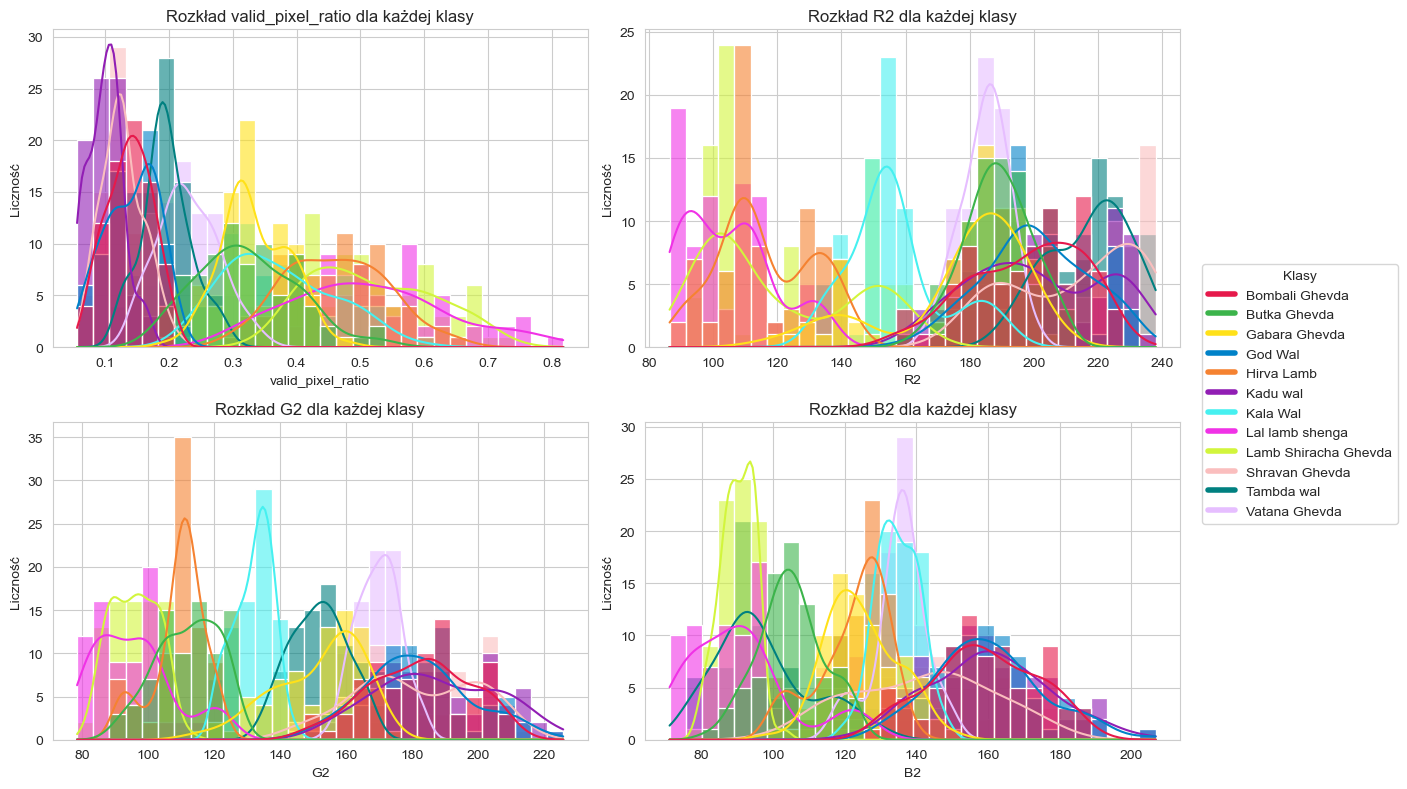

In [66]:
sns.set_style("whitegrid")


features = ["valid_pixel_ratio", "R2", "G2", "B2"]


fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)


handles = []
labels = []

for ax, feature in zip(axes.flatten(), features):
    plot = sns.histplot(data=df, x=feature, hue="class", kde=True, bins=30, 
                        palette=colors, alpha=0.6, ax=ax)

    ax.set_title(f"Rozkład {feature} dla każdej klasy")
    ax.set_xlabel(feature)
    ax.set_ylabel("Liczność")

    if plot.legend_:
        for h, l in zip(*plot.get_legend_handles_labels()):
            if l not in labels:  
                handles.append(h)
                labels.append(l)

    
    ax.legend_.remove()


if not labels:
    labels = df["class"].unique().tolist()
    handles = [plt.Line2D([0], [0], color=sns.color_palette(colors)[i], lw=4) for i in range(len(labels))]

fig.legend(handles, labels, title="Klasy", loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 1, 1])  
plt.show()

##### Rozkłady dla każdej są zdecydowanie bardziej zróżnicowane 
##### Są teź zdecydowanie różne między sobą - zgodnie z intuicją (fasolki mają różne dominujące kolory)

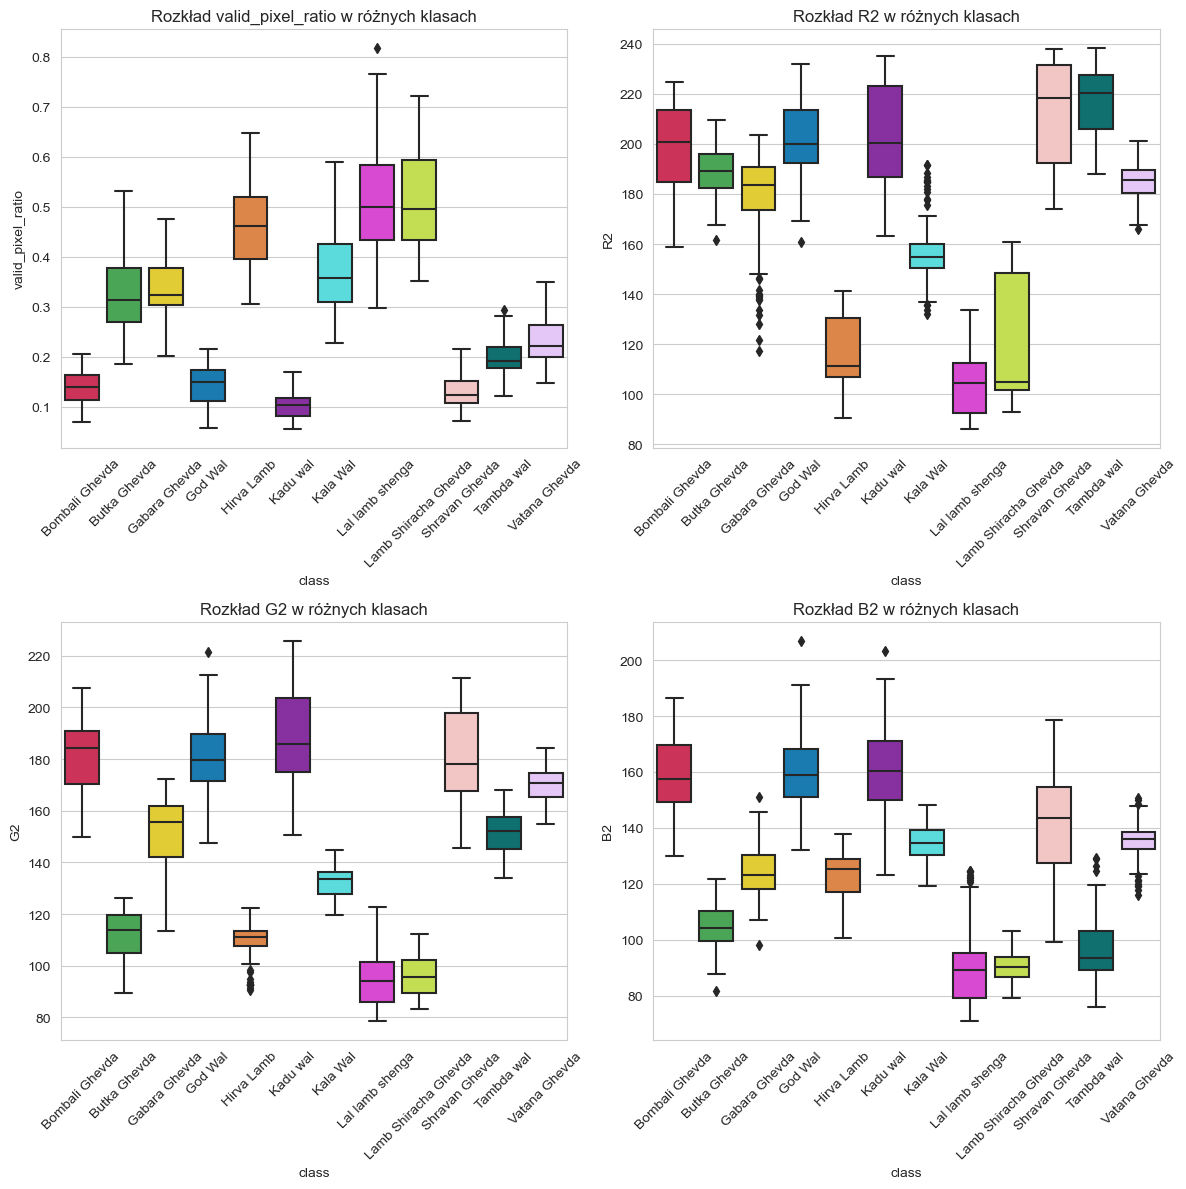

In [67]:


plt.figure(figsize=(12, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x="class", y=feature, palette=colors)
    plt.xticks(rotation=45)
    plt.title(f"Rozkład {feature} w różnych klasach")

plt.tight_layout()
plt.show()

C:\Users\matja\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


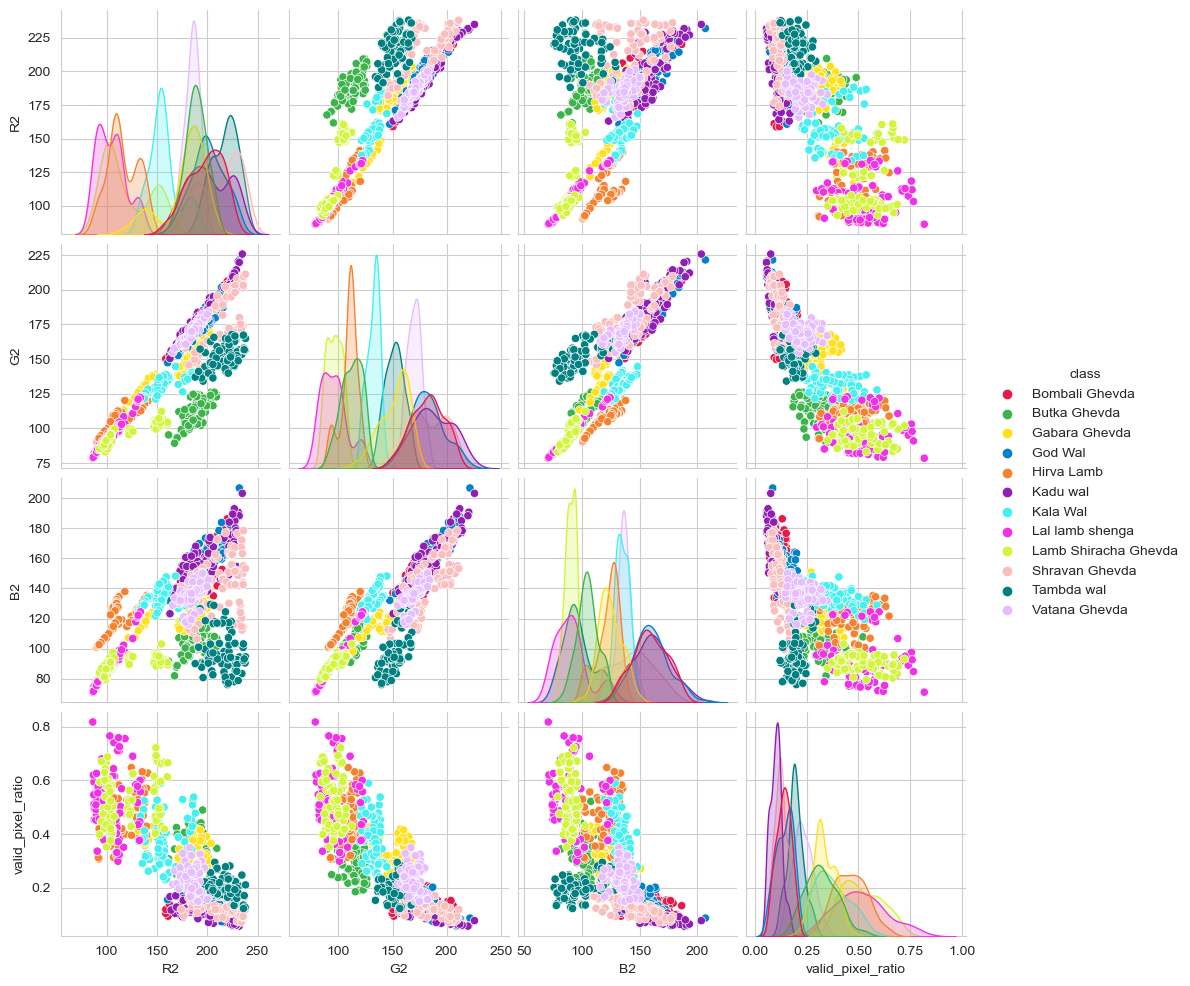

In [68]:
selected_columns = ["R2", "G2", "B2", "valid_pixel_ratio", "class"]
df_selected = df[selected_columns]


sns.pairplot(df_selected, hue="class", diag_kind="kde", palette=colors)
plt.show()

##### Nowe średnie RGB są mniej skorelowane (choć nadal silnie)
##### Brak korelacji valid_pixel_ratio z pozostałymi cechami

In [69]:
#### Jako kolejną potencjalnie użyteczną cechę wyznaczamy kontrast zdjęcia - odchylenie standardowe wartości jasności pikseli

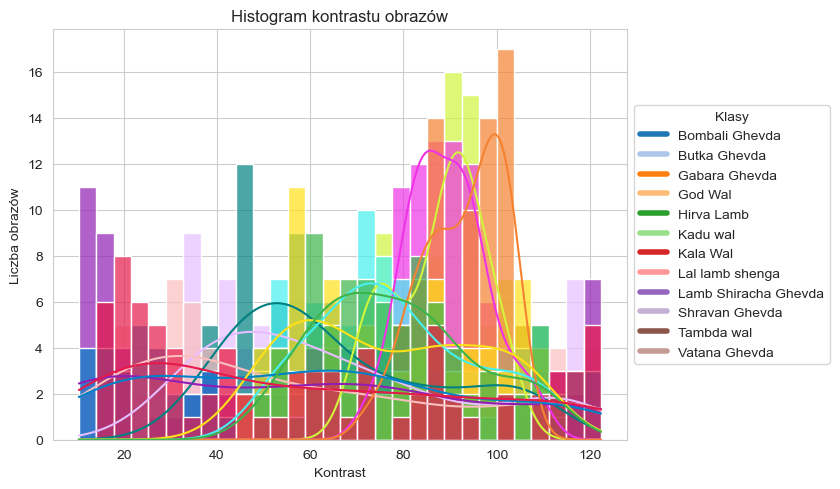

In [70]:
def image_contrast(img_path):
    """Oblicza kontrast obrazu jako odchylenie standardowe wartości jasności pikseli."""
    with Image.open(img_path) as img:
        img = img.convert("L")  
        img_array = np.array(img)
        return np.std(img_array)  

for class_folder in os.listdir(data_path): 
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):  
        for file in os.listdir(class_path):  
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_path, file)
                data.append({
                    "class": class_folder,
                    "filename": file,
                    "path": img_path,
                    "contrast": image_contrast(img_path)
                })


contrast_df = pd.DataFrame(data)


plt.figure(figsize=(10, 5))
ax = sns.histplot(contrast_df, x="contrast", hue="class", bins=30, kde=True, palette=colors, alpha=0.7)


handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()  



if not labels:
    labels = contrast_df["class"].unique().tolist()
    handles = [plt.Line2D([0], [0], color=sns.color_palette("tab20")[i], lw=4) for i in range(len(labels))]


plt.legend(handles, labels, title="Klasy", loc="center left", bbox_to_anchor=(1, 0.5))


plt.xlabel("Kontrast")
plt.ylabel("Liczba obrazów")
plt.title("Histogram kontrastu obrazów")


plt.tight_layout(rect=[0, 0, 0.85, 1])


plt.show()

##### Dla większości kategorii - rozkłady zbliżone do normalnych o różnych średnich
##### zastanawia wzrost liczby obserwownaych przypadków dla największej wartości 120

#### Ponieważ w powyższym przypadku na wynik również wpływały czarne pasy oraz stosunek obszaru zajmowanego przez fasolkę do całości zdjęcia, zbadajmy kontrast bez tych elementów  (filtr jak wcześniej)

In [71]:
def image_contrast_without_extreme_values(img_path):
    """Oblicza kontrast obrazu jako odchylenie standardowe wartości jasności pikseli,
    ignorując piksele o wartościach <3 i >250.
    """
    with Image.open(img_path) as img:
        img = img.convert("L")  # Konwersja do skali szarości
        img_array = np.array(img)

        # Usuwamy piksele o wartościach <3 i >250
        valid_pixels = img_array[(img_array >= 3) & (img_array <= 250)]

        if valid_pixels.size > 0:
            return np.std(valid_pixels)  # Kontrast = odchylenie standardowe wartości jasności
        else:
            return 0  # Jeśli nie ma żadnych ważnych pikseli, zwracamy 0


data = []


for class_folder in os.listdir(data_path): 
    class_path = os.path.join(data_path, class_folder)
    if os.path.isdir(class_path):  
        for file in os.listdir(class_path):  
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_path, file)
                data.append({
                    "class": class_folder,
                    "filename": file,
                    "path": img_path,
                    "contrast2": image_contrast_without_extreme_values(img_path)
                })


#### Badamy rozkłady według klas tak zdefiniowanego kontrastu

In [72]:
df["contrast2"] = df["path"].apply(image_contrast_without_extreme_values)

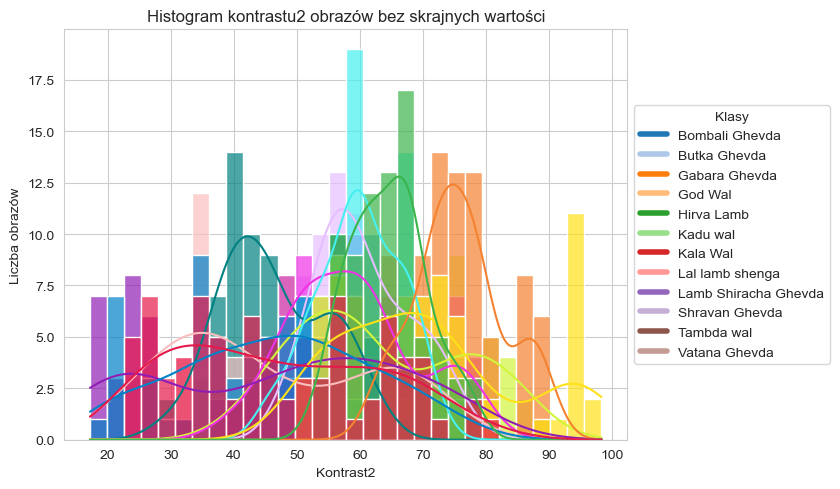

In [73]:
contrast2_df = df[["class","contrast2"]]


plt.figure(figsize=(10, 5))
ax = sns.histplot(contrast2_df, x="contrast2", hue="class", bins=30, kde=True, palette=colors, alpha=0.7)


handles, labels = ax.get_legend_handles_labels()
ax.legend_.remove()  




if not labels:
    labels = contrast_df["class"].unique().tolist()
    handles = [plt.Line2D([0], [0], color=sns.color_palette("tab20")[i], lw=4) for i in range(len(labels))]


plt.legend(handles, labels, title="Klasy", loc="center left", bbox_to_anchor=(1, 0.5))


plt.xlabel("Kontrast2")
plt.ylabel("Liczba obrazów")
plt.title("Histogram kontrastu2 obrazów bez skrajnych wartości")


plt.tight_layout(rect=[0, 0, 0.85, 1])


plt.show()

##### Zakresy kontrastów dla każdej klasy są teraz bardziej zwarte

#### Zestawiamy nową cechę z wcześniejszymi

C:\Users\matja\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


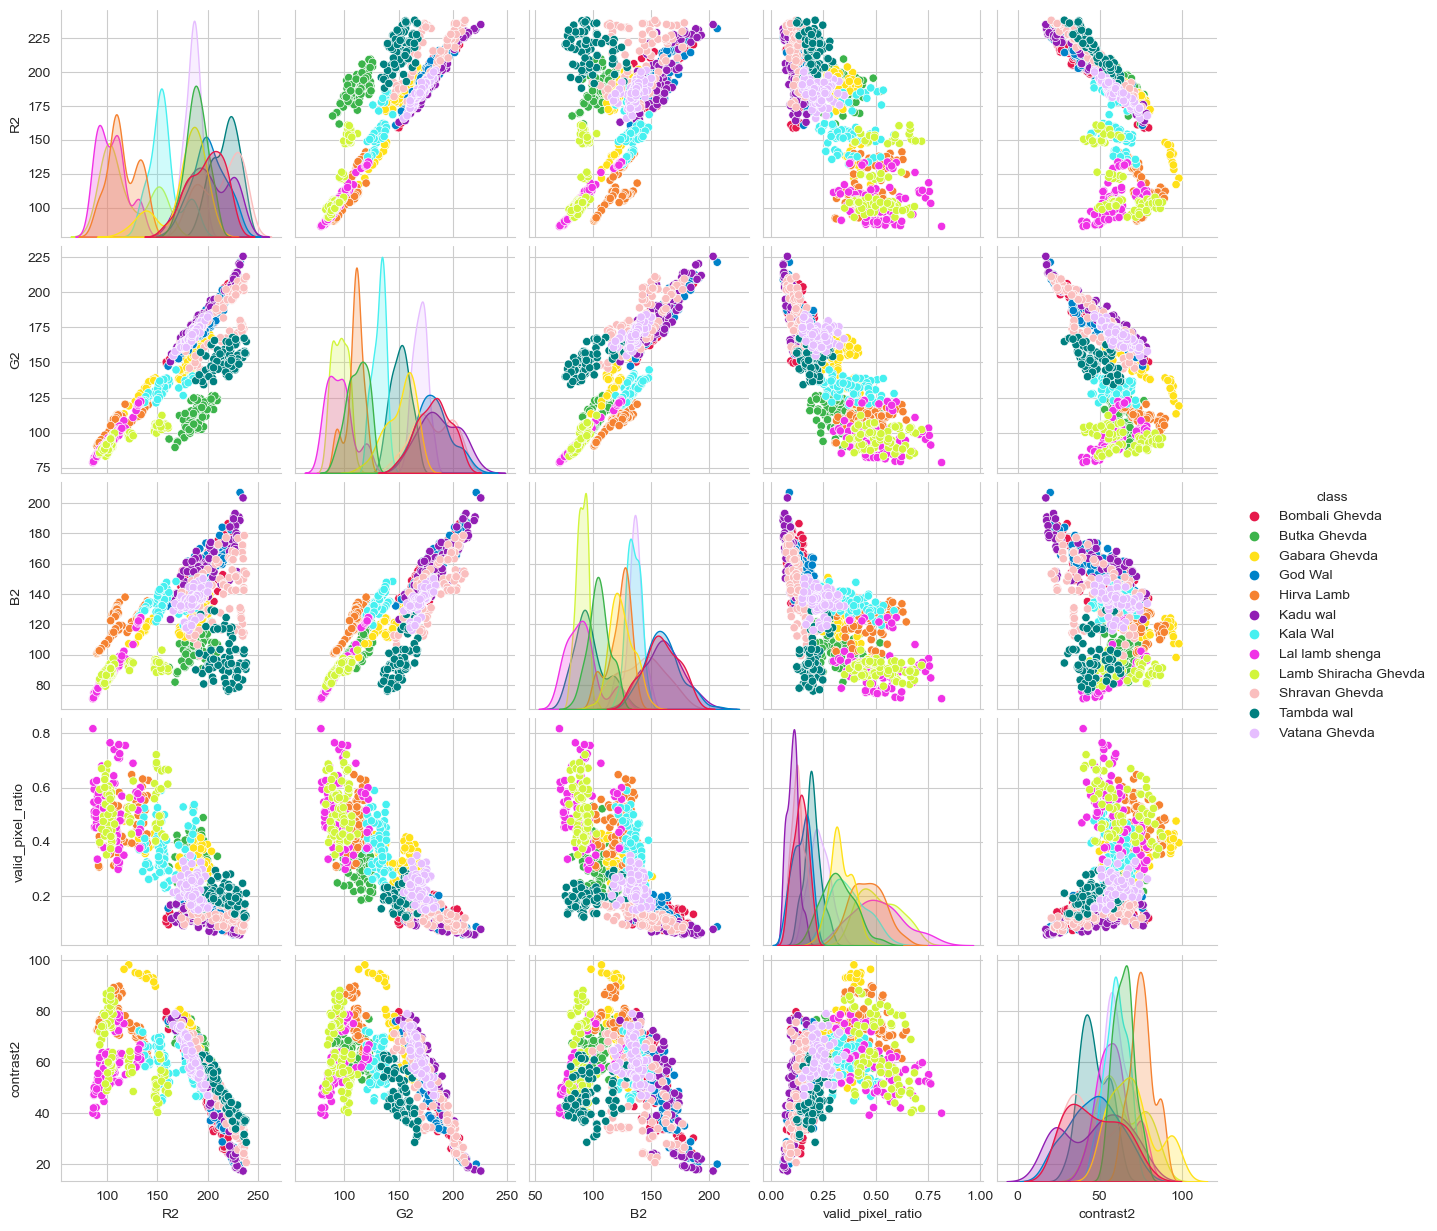

In [74]:
selected_columns = ["R2", "G2", "B2","valid_pixel_ratio","contrast2", "class"]
df_selected = df[selected_columns]
sns.pairplot(df_selected, hue="class", diag_kind="kde", palette=colors)
plt.show()

### Oprócz średniej koloru badamy możemy badać rozkład
#### Dzielimy dla każdego koloru możliwy zakres intensywności na n binów i zliczamy wpadające do nich piksele

In [75]:
# ukazanie ramki danych było sugestią zespołu walidacyjnego
def calculate_rgb_distribution(df, path_column, n=4):
    results = []

    # Tworzenie nazw kolumn dla przedziałów RGB
    bin_labels = [f"r_bin_{i}" for i in range(n)] + \
                 [f"g_bin_{i}" for i in range(n)] + \
                 [f"b_bin_{i}" for i in range(n)]

    for path in df[path_column]:
        try:
            # Otwórz obraz i konwertuj do RGB
            image = Image.open(path).convert('RGB')
            img_array = np.array(image)
            
            # Spłaszcz tablicę do kształtu (num_pixels, 3)
            pixels = img_array.reshape(-1, 3)
            
            # Oblicz jasność jako średnia z R, G, B
            brightness = pixels.mean(axis=1)
            
            # Filtrowanie pikseli według jasności
            valid_pixels = pixels[(brightness >= 3) & (brightness <= 250)]
            
            if len(valid_pixels) == 0:
                results.append([path] + [0] * (3 * n))
                continue
            
            # Oblicz histogramy dla R, G, B
            hist_r, _ = np.histogram(valid_pixels[:, 0], bins=n, range=(0, 255))
            hist_g, _ = np.histogram(valid_pixels[:, 1], bins=n, range=(0, 255))
            hist_b, _ = np.histogram(valid_pixels[:, 2], bins=n, range=(0, 255))

            # Normalizacja do procentowego rozkładu
            total_pixels = valid_pixels.shape[0]
            hist_r = (hist_r / total_pixels).tolist()
            hist_g = (hist_g / total_pixels).tolist()
            hist_b = (hist_b / total_pixels).tolist()

            results.append([path] + hist_r + hist_g + hist_b)

        except Exception as e:
            print(f"Error processing {path}: {e}")
            results.append([path] + [0] * (3 * n))

    # Tworzenie DataFrame z wynikami
    columns = [path_column] + bin_labels
    result_df = pd.DataFrame(results, columns=columns)
    
    return result_df


df = df.join(calculate_rgb_distribution(df, 'path', n=5).assign(path=lambda x: x['path'].astype(str)).set_index('path'), on='path')
df.head()


,class,filename,path,brightness,R,G,B,R2,G2,B2,...,g_bin_0,g_bin_1,g_bin_2,g_bin_3,g_bin_4,b_bin_0,b_bin_1,b_bin_2,b_bin_3,b_bin_4
0,Bombali Ghevda,1.jpg,Dataset_split/test\Bombali Ghevda\1.jpg,249.624143,251.923571,248.911000,247.177857,216.420732,202.136179,177.727642,...,0.000000,0.000714,0.030000,0.137143,0.832143,0.000714,0.017857,0.084286,0.172857,0.724286
1,Bombali Ghevda,10.jpg,Dataset_split/test\Bombali Ghevda\10.jpg,245.108000,248.839571,244.476000,238.508571,205.204288,187.279950,155.097100,...,0.000000,0.014815,0.080988,0.124444,0.779753,0.005432,0.057284,0.125926,0.241975,0.569383
2,Bombali Ghevda,10_aug0.jpg,Dataset_split/test\Bombali Ghevda\10_aug0.jpg,209.073286,212.869000,208.344286,202.751429,178.692718,166.423623,144.055062,...,0.073809,0.021932,0.067904,0.109237,0.727119,0.080135,0.054407,0.113876,0.189372,0.562210
3,Bombali Ghevda,10_aug1.jpg,Dataset_split/test\Bombali Ghevda\10_aug1.jpg,247.581571,250.652571,246.678429,244.036714,204.919608,186.786275,160.270588,...,0.004645,0.007299,0.074983,0.104180,0.808892,0.004645,0.049104,0.112143,0.166556,0.667551
4,Bombali Ghevda,10_aug2.jpg,Dataset_split/test\Bombali Ghevda\10_aug2.jpg,244.418571,248.884143,243.218000,238.641857,205.796610,186.129430,154.115562,...,0.006487,0.012048,0.052363,0.095922,0.833179,0.010195,0.039852,0.091288,0.188601,0.670065


### Zapis oczyszczonych i znormalizowanych danych 

In [76]:
#df.to_csv("train_data_with_features.csv", index=False)
df.to_csv("test_data_with_features.csv", index=False)